In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import normalize

In [17]:
def augFeatures(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['year'] = data['Date'].dt.year
    data['month'] = data['Date'].dt.month
    data['day'] = data['Date'].dt.day
    data['week'] = data['Date'].dt.dayofweek
    data = data.drop(['Date'], axis=1)
    return data

In [18]:
data = pd.read_csv('6269_adapt.csv')
stock = pd.read_csv('stock_index.csv')
stock = stock.rename(columns={'Open':'s_open', 'High':'s_high', 'Low':'s_low', 'Close':'s_close'})
stock = stock.drop(['Date'], axis=1)
train = pd.concat([data, stock], axis=1, join='inner')
train = augFeatures(train)

In [19]:
# build Data, use last 5 days to predict next 5 days
def buildTrain(Train, pastDay=5, futureDay=5):
    Y = Train['Close']
    X = Train.drop(['Close'], axis=1)
    X = normalize(X.values)
    x_test = X[Train.iloc[len(Train)-10:len(Train)-5].index]
    x_train, y_train = [], []
    for i in range(Train.shape[0]-futureDay-pastDay-5):
        x_train.append(np.array(X[i:i+pastDay]))
        y_train.append(np.array(Y.iloc[i+pastDay:i+pastDay+futureDay]))
    return np.array(x_train), np.array(y_train), x_test

In [20]:
def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [21]:
def splitData(X,Y,rate):
  x = int(X.shape[0]*rate)
  y = int(Y.shape[0]*rate)
  X_train = X[x:]
  Y_train = Y[y:]
  X_val = X[:x]
  Y_val = Y[:y]
  return X_train, Y_train, X_val, Y_val

In [22]:
# Build training data and normalization
X_train, Y_train, X_pre = buildTrain(train, pastDay=5, futureDay=5)

# Shuffle Data
X_train, Y_train = shuffle(X_train, Y_train)

# Split Data to training set and validation set
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

In [24]:
# Build Model
def buildOneToOneModel(shape):
  model = Sequential()
  model.add(LSTM(units = 256, input_shape=(shape[1], shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 256, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(1)))
  model.add(Flatten())
  model.add(Dense(64, activation='linear'))
  model.add(Dense(32, activation='linear'))
  model.add(Dense(32, activation='relu'))
  # Add output layer
  model.add(Dense(5))
  # Compiling the RNN
  model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
  model.summary()
  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 256)            274432    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              257       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

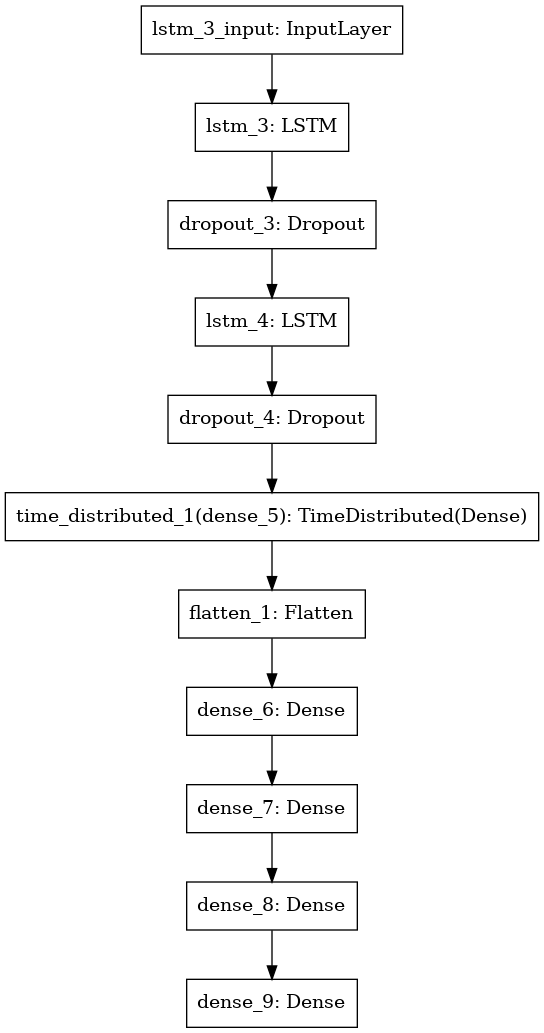

In [25]:
from keras.utils import plot_model
model = buildOneToOneModel(X_train.shape)
plot_model(model, to_file='model_lstm.png')

In [26]:
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
train_history = model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Epoch 1/1000
31/31 [==============================] - 7s 118ms/step - loss: 52.4100 - mean_absolute_error: 52.4100 - val_loss: 39.2451 - val_mean_absolute_error: 39.2451
Epoch 2/1000
31/31 [==============================] - 2s 77ms/step - loss: 36.1897 - mean_absolute_error: 36.1897 - val_loss: 36.0649 - val_mean_absolute_error: 36.0649
Epoch 3/1000
31/31 [==============================] - 2s 68ms/step - loss: 35.3385 - mean_absolute_error: 35.3385 - val_loss: 35.8390 - val_mean_absolute_error: 35.8390
Epoch 4/1000
31/31 [==============================] - 2s 57ms/step - loss: 35.7807 - mean_absolute_error: 35.7807 - val_loss: 35.8587 - val_mean_absolute_error: 35.8587
Epoch 5/1000
31/31 [==============================] - 2s 61ms/step - loss: 35.0807 - mean_absolute_error: 35.0807 - val_loss: 35.8282 - val_mean_absolute_error: 35.8282
Epoch 6/1000
31/31 [==============================] - 2s 53ms/step - loss: 35.0308 - mean_absolute_error: 35.0308 - val_loss: 36.1657 - val_mean_absolute_

In [27]:
# loss function
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

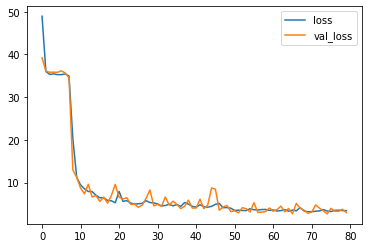

In [28]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [29]:
# save my model
#model.save('stock_lstm.h5')

In [30]:
test = model.evaluate(X_val, Y_val, batch_size=128)
print('Test Result: ', test)

4/4 [==============================] - 0s 16ms/step - loss: 2.9821 - mean_absolute_error: 2.9821
Test Result:  [2.982072114944458, 2.982072114944458]


In [31]:
# Predict the future price with trained model
X_pre = np.array([X_pre])
print('Predict Result', model.predict(X_pre))

Predict Result [[122.49197  122.984795 122.79702  123.202385 123.147026]]


In [32]:
from keras.models import load_model
model = load_model('stock_lstm_v1.h5')
print('Predict Result', model.predict(X_pre))

Predict Result [[123.25262  124.66886  124.978134 124.51701  124.59271 ]]
